### Predicting the sale price of bulldozers sold at auctions.

The data is downloaded from: https://www.kaggle.com/c/bluebook-for-bulldozers/data

### Problem definition

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.

### Data 

The data is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. 
* Test.csv is the test set.

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

There are several fields towards the end of the file on the different options a machine can have.  The descriptions all start with "machine configuration" in the data dictionary.  Some product types do not have a particular option, so all the records for that option variable will be null for that product type.  Also, some sources do not provide good option and/or hours data.
The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).

### Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

Note: the goal for most regression evaluation metrics is to minimize the error. In this case minimize RMSLE.

### Features

* SalesID	-  unique identifier of a particular sale of a machine at auction
* MachineID	-  identifier for a particular machine;  machines may have multiple sales
* ModelID	-  identifier for a unique machine model (i.e. fiModelDesc)
* datasource	-  source of the sale record;  some sources are more diligent about reporting attributes of the machine than others.  Note that a particular datasource may report on multiple auctioneerIDs.
* auctioneerID	-  identifier of a particular auctioneer, i.e. company that sold the machine at auction.  Not the same as datasource.
* YearMade	-  year of manufacturer of the Machine
* MachineHoursCurrentMeter	-  current usage of the machine in hours at time of sale (saledate);  null or 0 means no hours have been reported for that sale
* UsageBand	-  value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the * fiBaseModel;  e.g. 'Low' means this machine has less hours given it's lifespan relative to average of fiBaseModel.
* Saledate	-  time of sale
* Saleprice	-  cost of sale in USD
* fiModelDesc	-  Description of a unique machine model (see ModelID); concatenation of fiBaseModel & fiSecondaryDesc & * * fiModelSeries & fiModelDescriptor
* fiBaseModel	-  disaggregation of fiModelDesc
* fiSecondaryDesc	-  disaggregation of fiModelDesc
* fiModelSeries	-  disaggregation of fiModelDesc
* fiModelDescriptor	-  disaggregation of fiModelDesc
* ProductSize  - The size class grouping for a product group. Subsets within product group. 
* ProductClassDesc	-  description of 2nd level hierarchical grouping (below ProductGroup) of fiModelDesc
* State	-  US State in which sale occurred
* ProductGroup	-  identifier for top-level hierarchical grouping of fiModelDesc
* ProductGroupDesc	-  description of top-level hierarchical grouping of fiModelDesc
* Drive_System - machine configuration;  typcially describes whether 2 or 4 wheel drive
* Enclosure	machine configuration - does machine have an enclosed cab or not
* Forks	machine configuration - attachment used for lifting
* Pad_Type	machine configuration - type of treads a crawler machine uses
* Ride_Control -	machine configuration - optional feature on loaders to make the ride smoother
* Stick	machine - configuration - type of control 
* Transmission	- machine configuration - describes type of transmission;  typically automatic or manual
* Turbocharged	- machine configuration - engine naturally aspirated or turbocharged
* Blade_Extension	- machine configuration - extension of standard blade
* Blade_Width -	machine configuration - width of blade
* Enclosure_Type -	machine configuration - does machine have an enclosed cab or not
* Engine_Horsepower	- machine configuration - engine horsepower rating
* Hydraulics -	machine configuration - type of hydraulics
* Pushblock -	machine configuration - option
* Ripper -	machine configuration - implement attached to machine to till soil
* Scarifier	- machine configuration - implement attached to machine to condition soil
* Tip_control -	machine configuration - type of blade control
* Tire_Size -	machine configuration - size of primary tires
* Coupler -	machine configuration - type of implement interface
* Coupler_System -	machine configuration - type of implement interface
* Grouser_Tracks -	machine configuration - describes ground contact interface
* Hydraulics_Flow -	machine configuration - normal or high flow hydraulic system
* Track_Type -	machine configuration - type of treads a crawler machine uses
* Undercarriage_Pad_Width -	machine configuration - width of crawler treads
* Stick_Length -	machine configuration - length of machine digging implement
* Thumb -	machine configuration - attachment used for grabbing
* Pattern_Changer -	machine configuration - can adjust the operator control configuration to suit the user
* Grouser_Type -	machine configuration - type of treads a crawler machine uses
* Backhoe_Mounting -	machine configuration - optional interface used to add a backhoe attachment
* Blade_Type -	machine configuration - describes type of blade
* Travel_Controls -	machine configuration - describes operator control configuration
* Differential_Type -	machine configuration - differential type, typically locking or standard
* Steering_Controls -	machine configuration - describes operator control configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 

In [2]:
# Import data
df = pd.read_csv("data/TrainAndValid.csv",
                 low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

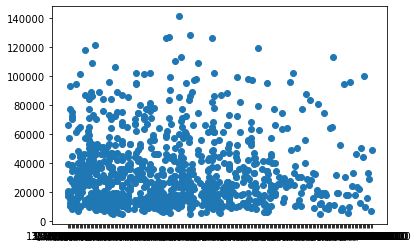

In [5]:
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000]);

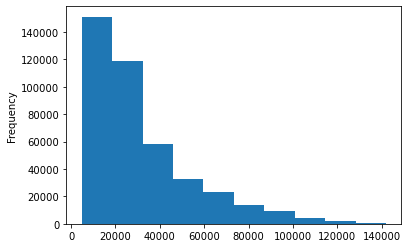

In [6]:
df.SalePrice.plot.hist();

### Parsing dates

When working with time series data we want to reach time and date components as much as possible

We can point to pandas which columns are dates using `parse_dates`

In [7]:
# Importing data wit parse dates
df = pd.read_csv("data/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"]);

In [8]:
df.saledate.dtype

dtype('<M8[ns]')

In [9]:
df.saledate[:100]

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
        ...    
95   2005-12-15
96   2004-01-29
97   2008-09-18
98   2005-11-03
99   2006-06-01
Name: saledate, Length: 100, dtype: datetime64[ns]

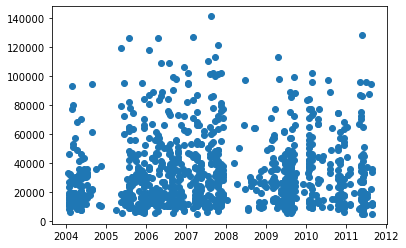

In [10]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [11]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [12]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

It's good idea to sort data by date when working with time series data

In [13]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [14]:
# Make a copy of df
df_tmp = df.copy()

### Add datetime parameters for `saledate` column

In [15]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayofYear'] = df_tmp.saledate.dt.dayofyear

In [16]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [17]:
# Now we can drop the saledate column
df_tmp.drop("saledate", axis=1, inplace=True)

In [18]:
# Check values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

### Modelling

### Convert strings to categories

One way to turn data into numbers is by converting them into pandas categories

Datatypes compatibile with pandas:
https://pandas.pydata.org/docs/reference/general_utility_functions.html

In [19]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [20]:
### Find columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [21]:
# Example to explain how df.items() works in the loop above:
random_dict = {"key1": "hello",
               "key2": "yello"}

for key, value in random_dict.items():
    print(f"This is a key: {key}",
          f"This is a value: {value}")

This is a key: key1 This is a value: hello
This is a key: key2 This is a value: yello


In [22]:
# Let's turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [23]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [24]:
df_tmp.state.cat.categories
# Under the hood, pandas is treating those values as numbers. Even now they are in alphabetical order, whereas in the df
# they were not ordered like that

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [25]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [26]:
### Now let's check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [27]:
### Save preprocessed data 
df_tmp.to_csv("data/train_tmp.csv", index=False)

### Fill numeric missing values

In [28]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofWeek
saleDayofYear


In [29]:
# Check which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [30]:
# Fill numeric rows with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

# We use median not mean because mean is sensitive when there are a lot of examples (and they can differ much).
# For example if we have 100 people with $10 and one person with $100000 the mean will have no value for us

In [31]:
# And we can check again if there are some null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [32]:
# Check how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [33]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorical variables into numbers

In [34]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [35]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes+1

In [36]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [37]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 81.1 MB


In [38]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [39]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

### Building machine learning model 

In [40]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,       # -1 means using all processors 
                              random_state=42) # ranodom_state acts like random.seed

model.fit(df_tmp.drop("SalePrice", axis = 1), df_tmp["SalePrice"])

RandomForestRegressor(n_jobs=-1, random_state=42)

### Splitting data into train/validation sets

We imported trainandvalid set so now we will split the data set into training and validation sets so it would look like we are working on "live series" example which wasn't split like on kaggle 

In [41]:
df_val = df_tmp[df_tmp.saleYear==2012]
df_train = df_tmp[df_tmp.saleYear!=2012]

len(df_val), len(df_train)

(11573, 401125)

In [42]:
# Split into X and y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building anevaluation function

In the kaggle competition they require RMSLE (root_mean squared log error)

**Mean squared log error** - this one has more to do with ratio (so as an example think of being 10% off)

**Mean absolute error** - you make predictions on all of the examples then subtract your predictions from your actual values and take the average (so how much on average is your prediction from the actual value - in here SalePrice) - so as an example instead of 10% that's being like $10 off

In [43]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores 

### Testing a model on a subset (to tune the hyperparameters)

In [44]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                               random_state=42,
                               max_samples = 10000) 

In [45]:
%%time
model.fit(X_train, y_train)

Wall time: 16.3 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [46]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

#### Hyperparameter tuning with RandomizedSearchCV

In [47]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1,
                                                    random_state=42),
                              param_distributions = rf_grid,
                              n_iter = 2,
                              cv = 5,
                              verbose = True)

# Fit RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 2min 49s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [48]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 10,
 'min_samples_leaf': 15,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [49]:
# Evaluate RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 6362.54766798879,
 'Valid MAE': 7948.566081709577,
 'Training RMSLE': 0.2867240744575243,
 'Valid RMSLE': 0.31563410256581886,
 'Training R^2': 0.8169541338969134,
 'Valid R^2': 0.7858445895656051}

### Train a model with the best hyperparameters

Those hypyrparameters were found after 100 iterations of RandomizedSearchCV

In [50]:
%%time

ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf = 1,
                                    min_samples_split = 14, 
                                    max_features = 0.5,
                                    n_jobs = -1,
                                    max_samples = None)

ideal_model.fit(X_train, y_train)

Wall time: 1min 42s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [51]:
show_scores(ideal_model)

{'Training MAE': 2952.6286927168444,
 'Valid MAE': 5959.355701379189,
 'Training RMSLE': 0.1444025557358471,
 'Valid RMSLE': 0.24656934320728374,
 'Training R^2': 0.9589268422029561,
 'Valid R^2': 0.8814292504563314}

### Make predictions od test data 

In [52]:
# Import the test data
df_test = pd.read_csv("data/Test.csv", 
                      low_memory = False,
                      parse_dates = ['saledate'])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [53]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [54]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

### Preprocessing the data (getting the test set in the same format as training dataset)

In [57]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofWeek"] = df.saledate.dt.dayofweek
    df['saleDayofYear'] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Fill categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [58]:
# Process test data 
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [59]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [60]:
# Still different size than the training set ...

In [62]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [63]:
# Manually adjust df_test to have auctioneerID_is_missing column 
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [64]:
# Now we can make predictions on test data
test_preds = ideal_model.predict(df_test)
test_preds

array([22928.89091473, 20063.73540345, 46037.62474642, ...,
       15827.43218348, 18884.65430204, 26219.89169115])

Format predictions into the same format Kaggle is after:

https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [65]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,22928.890915
1,1227844,20063.735403
2,1227847,46037.624746
3,1227848,65834.262023
4,1227863,48269.932490
...,...,...
12452,6643171,43162.815491
12453,6643173,13928.029757
12454,6643184,15827.432183
12455,6643186,18884.654302


In [66]:
# Export prediction data 
df_preds.to_csv("data/test_predictions.csv", index=False)

### Feature importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the `target variable` (SalePrice)

In [69]:
# Find feature importance of out best model
ideal_model.feature_importances_

array([3.32363540e-02, 1.85784070e-02, 3.84574934e-02, 1.69417840e-03,
       3.36749230e-03, 2.09805750e-01, 3.27339405e-03, 9.91363232e-04,
       4.08956084e-02, 3.73908684e-02, 6.72487003e-02, 4.52840672e-03,
       1.91591949e-02, 1.58975544e-01, 4.27405892e-02, 6.02017927e-03,
       2.93752708e-03, 2.43446302e-03, 3.77448277e-03, 5.39543753e-02,
       4.54100686e-04, 6.63097567e-05, 1.29344370e-03, 1.53962836e-04,
       1.18940225e-03, 2.33709704e-05, 4.26694421e-04, 2.02087498e-02,
       2.02556764e-04, 1.55164525e-04, 4.96596329e-03, 3.28324888e-03,
       3.39499662e-03, 1.90125852e-03, 2.24879877e-03, 8.36419010e-03,
       8.79105049e-04, 1.44667462e-02, 2.79346029e-03, 4.28686380e-03,
       1.21343928e-03, 7.58955844e-04, 1.57766697e-03, 5.62736848e-04,
       1.11074344e-03, 3.84322326e-04, 4.44356476e-04, 2.51569198e-03,
       7.18634840e-04, 2.86584071e-04, 2.41871522e-04, 7.33786108e-02,
       3.83435162e-03, 5.66526821e-03, 2.93716743e-03, 9.82412354e-03,
      

In [70]:
len(ideal_model.feature_importances_)

102

In [75]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):   # We get only first 20. We don't need to see all of the features since we seek for the most important
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis() # Without that, the most important features were sorted from the least important

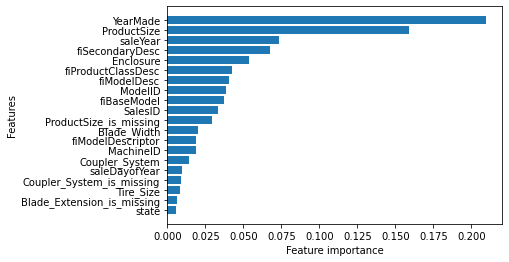

In [76]:
plot_features(X_train.columns, ideal_model.feature_importances_)

***Machine learning models to check*** : CatBoost, XGBoost.ai